$\qquad$ $\qquad$ $\qquad$  **TDA233 / DIT382 Algorithms for machine learning and inference: Homework 2** <br />
$\qquad$ $\qquad$ $\qquad$ **Goal: Get acquainted with different classification techniques.**<br />
$\qquad$ $\qquad$ $\qquad$                   **Grader: Linus Aronsson** <br />
$\qquad$ $\qquad$ $\qquad$                   **Submitted by: Anna Davoodi, 000808, annadav@student.chalmer.se; Nils Ledin, 020705, nilsled@student.chalmers.se** <br />

---

General guidelines:
*   All solutions to theoretical and pratical problems must be submitted in this ipynb notebook, and equations wherever required, should be formatted using LaTeX math-mode.
*   All discussion regarding practical problems, along with solutions and plots should be specified in this notebook. All plots/results should be visible such that the notebook do not have to be run. But the code in the notebook should reproduce the plots/results if we choose to do so.
*   Your name, personal number and email address should be specified above.
*   All tables and other additional information should be included in this notebook.
*   All the answers for theoretical questions must be filled in the cells created for you with "Your answer here" below each question, but feel free to add more cells if needed.
*   Before submitting, make sure that your code can run on another computer. That all plots can show on another computer including all your writing. It is good to check if your code can run here: https://colab.research.google.com.
* Upload both the .ipynb and the generatable .html file (that can be exported through File > Download As > HTML).

### General comments:
* **Throughout this assignment, feel free to use any *NumPy*-functions where you see fit.**
* **For the practical tasks there are comments marked with "TODO" in all parts that you need to change.**
* **Please note the slight changes in the notation from the lectures:**

  * Here, the dataset is represented as $\{(\mathbf{x}_n, y_n)\}_{n=1}^N$, where $x_n$ are vectors with attributes of dimension $D$ and $y_n$ is the associated labels ($y_n \in \{0,1\}$ for binary prediction). In the lectures, $t_n$ was instead used for the labels.

# 0. Dataset
**Run the code cell below to produce the dataset and some helper functions.**

In [3]:
from sklearn.datasets import make_gaussian_quantiles
import numpy as np
from matplotlib import pyplot as plt

# Randomly generate data from two different distributions
data_class1, _ = make_gaussian_quantiles(mean = [1,1], cov = 1.5, n_samples = 30, n_features=2, random_state=18)
data_class2, _ = make_gaussian_quantiles(mean = [-1,-1], cov= 0.75,n_samples = 8, n_features=2, random_state=4)

# Concatenate the data, and add labels
X_train = np.append(data_class1, data_class2, axis=0)
y_train = np.append(np.zeros(len(data_class1), dtype=np.int32),
                   np.ones(len(data_class2), dtype=np.int32))

# Consider new test point
X_test = np.array([[-0.6,-0.4]])

def plot_data(X_train, y_train, X_test, title = ''):
    # Plot the two data classes
    fig,ax = plt.subplots(figsize=(10,10))
    ax.plot(X_train[y_train == 0][:,0], X_train[y_train == 0][:,1], 'o', markersize=8)
    ax.plot(X_train[y_train == 1][:,0], X_train[y_train == 1][:,1], 's', markersize=8)

    # Plot test point (circles to help with distances)
    ax.plot(X_test[:,0], X_test[:,1], '*', markersize=10)

    plt.axis('square')
    ax.legend(['Class 0','Class 1','test point'])
    ax.grid()
    ax.set_title(title, fontsize=15);
    return fig, ax

def decision_boundary(model, fig, ax, levels = [0.1,0.5,0.9], labels = True):
    # Code for producing the plot
    X1 = np.linspace(*ax.get_xlim(),100)
    X2 = np.linspace(*ax.get_ylim(), 100)
    Z = np.zeros(X1.shape+X2.shape)

    for i,x1 in enumerate(X1):
        for j,x2 in enumerate(X2):
            _, y_prob = model.predict(np.array([x1,x2]).reshape(1,-1))
            Z[j,i] = y_prob[0,0]

    contours = ax.contour(X1,X2,Z, levels=levels)
    if labels:
        ax.clabel(contours, inline=1, fontsize=10)

    return fig, ax

# 1. K-Nearest-Neighbour Classification (5 pts)
A KNN classifier assigns a test instance to the majority class associated with its $K$ nearest training instances. Distance between instances is measured using Euclidean distance. Suppose we have the following training set of two classes (circles and squares) and a single test instance (star). Assume “unweighted” KNN (every nearest neighbor contributes equally to the final vote).

**Run the code in the cell below.**

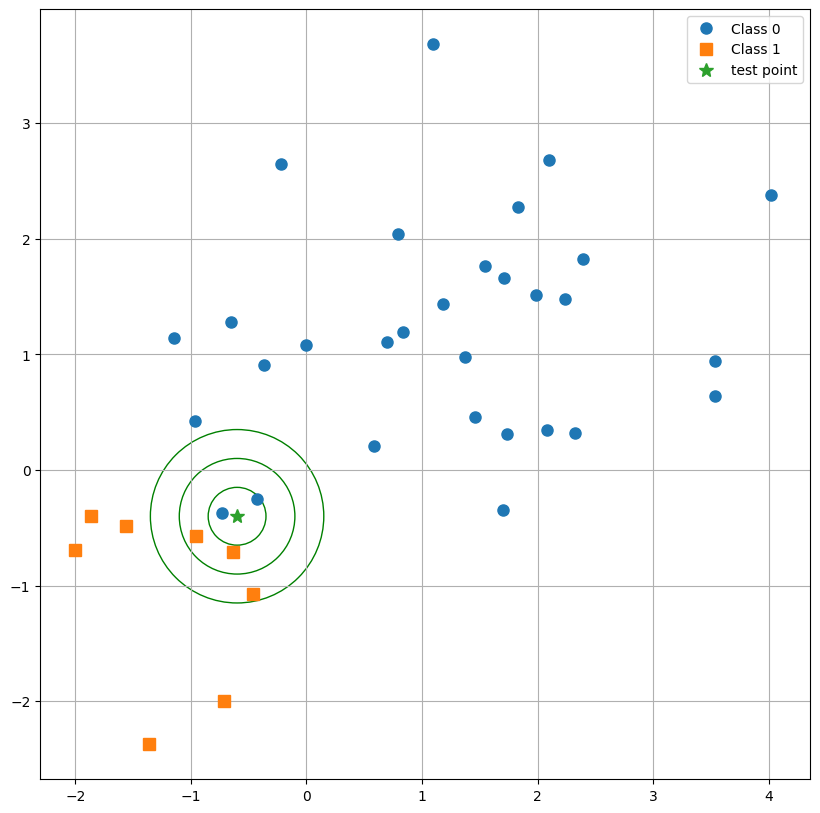

In [4]:
fig, ax = plot_data(X_train, y_train, X_test)

# Circles added to help visualize distance to points.
for r in np.arange(0.25,1,0.25):
    c = plt.Circle(X_test[0], r, color='g', fill=False)
    ax.add_artist(c)

### 1.1 Exercise 1 (2 pts)
a) What would be the class assigned to this test instance for $K=2$, $K=4$, $K=5$ and why? (**1 pt**)

b) The classification result is affected by the increasing $K$. What will be the maxinum value of K in this case? Why? (**1 pt**)<br />
(***Hint:*** After $K$ reaches a certain value, it is impossible for the classification results to change. Find this value!)


#### a)

For $K=2$ the test point would be assigned to class 0, this is due to the two nearest neighbours of the point are both of class 0. For $K=4$, the point has equal probability of being assigned to either class since the four closest points consist of equally many points of class 0 and class 1. For $K=5$ the test point would be assigned to class 1, since this is the dominating class out of the five closest points.

#### b)

This number is determined by the size of the smallest class, let us denote this size as $s$. If we let $K=2s+1$ we ensure that the larger class will always dominate no matter where the test point is placed. This is due to the fact that even if all the data points in the smaller class is within reach, they will always represent less than half of the $K$ nearest neighbors.

In our case, since the smallest class is class 1 with $s=8$, we obtain $K=17$.

### 1.2 Exercise 2 (3 pts)
In this task, we are going to complete a custom implementation of the unweighted K-Nearest-Neighbor classifier. A skeleton of the implementation can be found below, and the only function that is not finished is `predict(self, X_test)`.

In total, the algorithm stores three variables:
* `self.X_train`, `self.y_train`: All training data with labels.
* `self.n_neighbors`: Number of neighbors, i.e. $K$.

Your task is to finish the implementation of `predict(self, X_test)`. The distances between all test- and training instances have already been computed. In the loop below, the variable `dist_i` is an array containing the distances between test sample $i$ and all training points in `self.X_train`. Your task is to compute `y_pred_prob[i]`, which is an array with the probability for selecting each class in the dataset, e.g. for binary prediction we have $[1,0]$ (class 0), $[0,1]$ (class 1), or $[0.5,0.5]$ (tie).

Finish this implementation and verify your results in Exercise 1 by running the implementation for the aforementioned values of $K$ (2, 4, and 5).
<br />
***Hint:*** `np.unique` might be of interest.

In [5]:
from sklearn.metrics.pairwise import euclidean_distances
class K_Nearest_Neighbors():
    """
    Custom implementation of K-nearest-neighbors.

    Note: If two or more classes have the same amount of neighbors, the prediction
    will be random, i.e. tiebreaks are resolved randomly.
    """

    def __init__(self, n_neighbors):
        """
        Parameter(s):
            n_neighbors - Number of neighbors
        """
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train):
        """
        No training required. Store data and labels.
        --------------------
        Input(s):
            X_train   - Data of size (n_samples, n_features)
            y_train   - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        """
        Prediction of test data.
        --------------------
        Input(s):
            X_test   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels of size (n_samples,)
            y_pred_prob - Probabilistic labels of size (n_samples,n_classes)
        """
        n_samples = X_test.shape[0]
        unique_classes = np.unique(self.y_train)
        n_classes = len(unique_classes)
        K = self.n_neighbors

        y_pred = np.zeros(shape=(n_samples,), dtype=np.int32)
        y_pred_prob = np.zeros(shape=(n_samples, n_classes), dtype=np.float32)

        # Computes distances between all points in X_test and X_train.
        dist = euclidean_distances(X_test,self.X_train)
        
        for i in range(n_samples):
            
            dist_i = dist[i]
            # Sort and obtain indices of K nearest points
            K_nearest_ind = np.argsort(dist_i)[:K]
            # Obtain coordinates from labels of these points
            K_nearest_lable = self.y_train[K_nearest_ind]
            # Count instances of labels
            class_counts = np.bincount(K_nearest_lable, minlength=n_classes)
            
            # Obtain class by comparison
            y_pred_prob[i, :] = np.where(class_counts[0] > class_counts[1], [1, 0], 
                                np.where(class_counts[1] > class_counts[0], [0, 1], 
                                [0.5, 0.5]))
            
            # Selects the prediction randomly, based on y_pred_prob[i].
            y_pred[i] = np.random.choice(unique_classes, p=y_pred_prob[i])
            
        return y_pred, y_pred_prob


#### Run the code below after finishing the above implementation (no need to change anything).
Make sure that you understand the plot and that your implementation produces sensible results.

*Note:* What happens when $K$ is even? -> prob 0.5 that point belogs to either class, dist equal to K/2 nearest points


Train accuracy: 97.368 %
Predicted test class, K=2: 0


C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\3111419088.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted test class, K=%d: %d" %(K, y_pred_test))


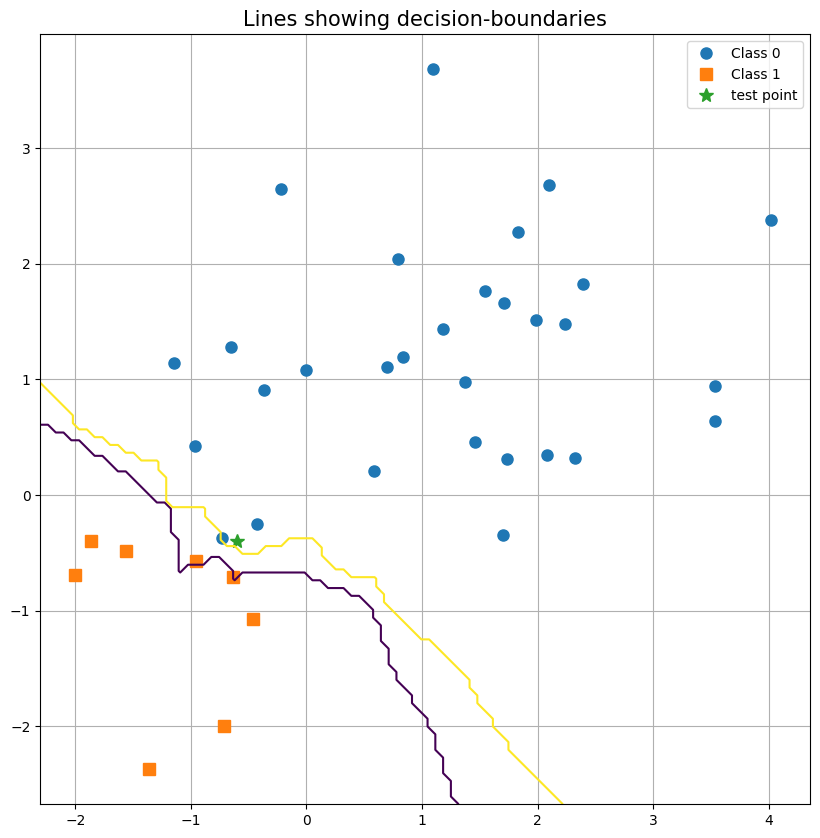

In [6]:
# Parameters (feel free to change)
K = 2

# Define and train the model
model = K_Nearest_Neighbors(n_neighbors = K)
model.fit(X_train, y_train)

# Predictions
y_pred_train,_ = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test,_ = model.predict(X_test)
print("Predicted test class, K=%d: %d" %(K, y_pred_test))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Lines showing decision-boundaries')
fig, ax = decision_boundary(model, fig, ax, levels=[0.4, 0.6], labels = False)

# 2. Naive Bayes Classifier (7 pts)

The Bayes classifier refers to a classifier using the predicitive probability:
$$
P(y_{n} = c | x_{n}, X, y) = \frac{p(x_{n}|y_{n} = c, X, y)P(y_{n} = c | X, y)}{p(x_{n}|X,y)}, \tag{1}
$$
where $X,y$ is the training data, $x_{n}$ a new test instance and $c$ its corresponding class.

Assume that the class-conditional densities are Gaussian, that is
$$
    p(x_{n}|y_{n} = c, X, y) = \mathcal{N}(\mu_{c}, \Sigma_{c}).
$$

Furthermore, assume a class size prior, i.e. the prior is set using the proportion of training points in class $c$:
$$
    P(y_{n} = c |X, y ) = \frac{N_c}{N}, \tag{2}
$$
where $N_c$ is the number of training objects belonging to class $c$, and $N$ is the total number of training objects.


### Exercise  2.1 (5 pts)
We consider a **binary** classification problem with **real valued data**, i.e. $x_n = [x_{n1}, x_{n2}]^T \in \mathbb{R}^2$ and $c=\{0,1\}$.


#### 1.  (2 pts)
In order to simplify the problem, we use the Naive Bayes assumption,
$$
    p(x_{n}|y_{n} = c, X, y) = \prod_{d=1}^2 p(x_{nd}|y_n = c, X, y) = \prod_{d=1}^2 \mathcal{N}(\mu_{cd}, \sigma_{cd}^2),
$$
which assumes that the two attributes of $x_n$ are independent of one another, i.e. the covariance matrix $\Sigma_{c}$ is diagonal.

Using this assumption, write the expression for the **naive Bayes** classifier, that is, derive
$$
P(y_{n} = c | x_{n} , X, y ).
$$

***HINT:*** Derive the maximum likelihood estimates for the parameters $\mu_{c}, \sigma_{c}$. Then express eq. 1 in terms of those estimates.


#### Solution:

We obtain the maximum likelihood estimates for $\mu_{cd}$ and $\sigma_{cd} $ by derivating the (log) likelihood function with respect to either parameter, setting these expression to 0 and rewriting in terms of the parameters. Note that the points in $X$ which are not classified as class $c$ are not going to affecting the probabilities of the parameters $\mu_c$ and $\sigma_c$. Hence, the rows in both $X$ and $y$ where $y\not = c$ are removed. The number of rows in the resulting matrix $X$ will now be denoted as $N_c$. In short, the likelihood is given by

$$\mathcal{L} = \prod_{d=1}^2 p(X,y|\mu_{cd}, \sigma_{cd}^2) =\prod_{d=1}^2 \prod_{i =1}^{N_c} \mathcal{N}(x_i;\:\mu_{cd},\ \sigma_{cd}^2) = \prod_{d=1}^2 \prod_{i=1}^{N_c} \frac{1}{\sqrt{2\pi\sigma_{cd}^2}} \exp\left(-\frac{(x_{id} - \mu_{cd})^2}{2\sigma_{cd}^2}\right).$$

Thus the log-likelihood (for a given $d$) is obtained as

$$ \log \mathcal{L}_d = \sum_{i=1}^{N_c} \left(\log (1) -\frac{1}{2} \log(2\pi\sigma_{cd}^2) - \frac{(x_{id} - \mu_{cd})^2}{2\sigma_{cd}^2} \right).
$$

The partial derivative of this likelihood w.r.t $\mu_{cd}$ set to zero is 

$$
\frac{\partial}{\partial \mu_{cd}} \log \mathcal{L}_d= \sum_{i=1}^{N_c} \left( \frac{x_{id} - \mu_{cd}}{\sigma_{cd}^2} \right) = 0.
$$

Solving for $\mu_{cd}$ 

$$ \sum_{i=1}^{N_c}  (x_{id} - \mu_{cd}) = 0 \Rightarrow \sum_{i=1}^{N_c} x_{id} = N_c \mu_{cd} \Rightarrow \mu_{cd} = \frac{1}{N_c} \sum_{i=1}^{N_c}  x_{id}.$$

Similarly for $\sigma_{cd}^2$, the partial derivative of the log-likelihood w.r.t to $\sigma_{cd}^2$ is

$$\frac{\partial}{\partial \sigma_{cd}^2} \log \mathcal{L}_d= \sum_{i=1}^{N_c}  \left( -\frac{1}{2\sigma_{cd}^2} + \frac{(x_{id} - \mu_{cd})^2}{2\sigma_{cd}^4} \right) = 0.
$$

Solving for $\sigma_{cd}^2$ yeilds

$$-\frac{N_c}{2\sigma_{cd}^2} + \frac{1}{2\sigma_{cd}^4} \sum_{i=1}^{N_c}  (x_{id} - \mu_{cd})^2 = 0 \Rightarrow \frac{N_c}{\sigma_{cd}^2} = \frac{1}{\sigma_{cd}^4} \sum_{i=1}^{N_c}  (x_{id} - \mu_{cd})^2 \Rightarrow \sigma_{cd}^2 = \frac{1}{N_c} \sum_{i=1}^{N_c}  (x_{id} - \mu_{cd})^2.
$$

Returning to the expression of the naive Bayes classifier, we can start by expressing it in the following way

$$p(y_{n} = c | x_{n}, X, y) = \frac{p(x_{n}|y_{n} = c, X, y)p(y_{n} = c | X, y)}{p(x_{n}|X,y)} = \frac{p(x_{n}|y_{n} = c, X, y)p(y_{n} = c | X, y)}{\sum_{j=0,1} p(x_{n}|y_n = j, X,y)p(y_n=j)}.$$

With the given assumptions, the above will result in

$$p(y_{n} = c | x_{n}, X, y) = \frac{\frac{N_c}{N}\prod_{d=1}^2\mathcal{N}(\mu_{cd},\sigma_{cd})}{\sum_{j=0,1}(\prod_{d=1}^2\mathcal{N}(\mu_{jd},\sigma_{jd}))\frac{N_j}{N}} = N_c\frac{\prod_{d=1}^2(2\pi\sigma_{cd}^2)^{-1/2}\text{exp}(-\frac{x_{nd}-\mu_{cd}^2}{2\sigma_{cd}^2})}{\sum_{j=0,1}N_j \cdot \prod_{d=1}^2 (2\pi \sigma_{jd}^2)^{-1/2}\text{exp}(-\frac{(x_{nd}-\mu_{jd})^2}{2\sigma_{jd}^2})}.$$


#### 2. (3 pts)
Derive the maximum likelihood estimate for $\mu_{c}, \Sigma_{c}$ when the covariance matrix is not diagonal, i.e, $\Sigma_{c}$ has 4 unknown scalars. This alleviates the "naive" assumption, since the feature components are no longer independent of one another.

***HINT:***
When deriving the MLE for $\Sigma_{c}$ it might be a good idea to consider $\partial /\partial \Sigma_{c}^{-1}$. Also, feel free to use the following properties:
$$
    \frac{\partial\ x^T A x}{\partial A} = x x^T, \qquad
    \frac{\partial\ x^T A x}{\partial x} = 2Ax, \qquad
    \frac{\partial\ \log |A|}{\partial A} = A^{-T},
$$
for a symmetric matrix $A$ and a vector $x$ that does not depend on $A$.

#### Solution:
We first realize that the points in $X$ that are not classified as $c$ will not affect the probabilities of $\mu_c$ and $\Sigma_c$. We therefore remove the rows of $X$ and $y$ where $y\not = c$. We will have $N_c$ remaining rows in X, the MLE is then

$$
\mathcal{L} =p(X,y|\mu_c,\ \Sigma_c) \propto \prod_{i=1}^{N_c} \frac{1}{\sqrt{|\Sigma_c|}}\exp\left(-\frac{1}{2}(x_i-\mu_c)^T\Sigma_c^{-1}(x_i-\mu_c)\right).
$$
To find the maximum, we take the log and then differentiate:
$$
\ln(\mathcal{L}) =\text{constant }- \frac{N_c}{2}\ln\left(|\Sigma_c|\right)-\sum_{i=1}^{N_c}\left(\frac{1}{2}(x_i-\mu_c)^T\Sigma_c^{-1}(x_i-\mu_c)\right).
$$

We now differentiate this expression with respect to first $\mu_c$ then $\Sigma_c$ and set equal to zero to find the maximum likelihood. 

$$
\frac{d}{d\mu_c}\ln(\mathcal{L}) = \sum_{i=1}^{N_c}\Sigma_c^{-1}(x_i-\mu_c) = 0 \implies \mu_c = \frac{1}{N_c}\sum_{i=1}^{N_c}x_i.
$$

Now we differentiate wrt $\Sigma_c$,

$$
\frac{d}{d\Sigma_c}\ln(\mathcal{L}) = -\frac{N_c}{2}(\Sigma_c^{-T})-\frac{1}{2}\sum_{i=1}^{N_c}(x_i-\mu_c)(x_i-\mu_c)^T\frac{d\Sigma_c^{-1}}{d\Sigma_c}.
$$

Now we make two notes. Because $\Sigma_c$ is symmetric (like all covariance matrices), $\Sigma_c^{-1}$ is also symmetric, so $\Sigma_c^{-T} = \Sigma_c^{-1}$. Second, we need to find the value of $d\Sigma_c^{-1}/d\Sigma_c$:

$$
I = \Sigma_c\Sigma_c^{-1} \implies dI/d\Sigma_c = d/d\Sigma_c(\Sigma_c\Sigma_c^{-1}) \implies 0 = \Sigma_c^{-1} + \Sigma_c d\Sigma_c^{-1}/d\Sigma_c \implies d\Sigma_c^{-1}/d\Sigma_c = -\Sigma_c^{-1}\Sigma_c^{-1}.
$$

With these tools we find that
$$
\frac{d}{d\Sigma_c}\ln(\mathcal{L}) = \frac{1}{2}\left(-N_c\Sigma_c^{-1}+\sum_{i=1}^{N_c}(x_i-\mu_c)(x_i-\mu_c)^T\Sigma_c^{-1}\Sigma_c^{-1}\right) = \frac{1}{2}\left(-N_cI + \sum_{i=1}^{N_c}(x_i-\mu_c)(x_i-\mu_c)^T\Sigma_c^{-1}\right)\Sigma_c^{-1}
$$
Now set this equal to zero to find the maximal probability:
$$
-N_cI + \sum_{i=1}^{N_c}(x_i-\mu_c)(x_i-\mu_c)^T\Sigma_c^{-1} = 0 \implies \Sigma_c = \frac{1}{N_c}\sum_{i=1}^{N_c}(x_i-\mu_c)(x_i-\mu_c)^T
$$

So the maximum likelihood estimators are $\mu_c = \frac{1}{N_c}\sum_{i=1}^{N_c}x_i,\ \Sigma_c = \frac{1}{N_c}\sum_{i=1}^{N_c}(x_i-\mu_c)(x_i-\mu_c)^T$ where we pick $x_i$ so that $y_i=c$. We note that they are both equal to regular sample estimators.

### Exercise  2.2 (2 pts)
Here, you will finish a custom implementation of a Gaussian Naive Bayes classifier.

The most important variables stored by the algorithm are:
* `self.mean`, and `self.std`: Dictionaries containing MLE for each class. (`self.mean[c]`$ =[\mu_{c1}, \mu_{c2}]$, and `self.std[c]`$ =[\sigma_{c1}, \sigma_{c2}]$)
* `self.prior`: Dictionary containing prior probability of each class.

Use your calculations from Exercise 2.1.1 and complete the unfinished function `predict(self, X_test)`. The 1-D Gaussian density function `gaussian_density(self, x, mu, std)` is already implemented and may be used.

In [ ]:
class GaussianNaiveBayes():
    """
    Custom implementation of a Gaussian Naive Bayes classifier.
    The parameters are estimated using MLE.
    """

    def __init__(self):
        """
        Parameter(s):
        """
        self.mean = {}
        self.std = {}
        self.prior = {}
        self.unique_classes = 0

    def get_class_parameters(self, X_class):
        """
        Estimating the MLE of the parameters.
        --------------------
        Input(s):
            X_class - Data points corresponding to a single class
        --------------------
        Output(s):
            mean_MLE - MLE of mean
            std_MLE  - MLE of scale
        """

        mean_MLE = np.mean(X_class, axis=0)
        std_MLE = np.std(X_class, axis=0)

        return mean_MLE, std_MLE

    def fit(self, X_train, y_train):
        """
        Compute model parameters using maximum likelihood estimates and a class size prior.
        --------------------
        Input(s):
            X_train   - Data of size (n_samples, n_features)
            y_train   - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """

        # Compute mean, variance and prior of each class
        self.unique_classes = np.unique(y_train)
        for uc in self.unique_classes:
            X_class = X_train[y_train == uc]
            c_mean, c_std = self.get_class_parameters(X_class)
            self.mean[uc] = c_mean
            self.std[uc] = c_std
            self.prior[uc] = X_class.shape[0]/X_train.shape[0]

    def gaussian_density(self, x, mu, std):
        """
        1-D Gaussian density function.
        --------------------
        Input(s):
            x   - Data point
            mu  - mean
            std - scale
        --------------------
        Output(s):-
            N(mu, std^2)

        """
        return 1/(std*np.sqrt(2*np.pi))*np.exp(-(1/2)*((x-mu)/std)**2)

    def predict(self, X_test):
        """
        Prediction of test data.
        --------------------
        Input(s):
            X_test   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels of size (n_samples,)
            y_pred_prob - Probabilistic labels of size (n_samples,n_classes)
        """

        n_samples = X_test.shape[0]
        y_pred_prob = np.zeros(shape=(n_samples,len(self.unique_classes)), dtype=np.float32)

        for i in range(n_samples):

            # Compute the probability of each class
            for uc in self.unique_classes:
                prob = self.prior[uc]
                for j in range(X_test.shape[1]):
                    prob *= self.gaussian_density(X_test[i,j], self.mean[uc][j], self.std[uc][j])
                y_pred_prob[i,uc] = prob

            #Normalize to a probability in range 0-1
            y_pred_prob[i,:] = y_pred_prob[i,:]/np.sum(y_pred_prob[i,:])


        y_pred = np.argmax(y_pred_prob, axis=-1)

        return y_pred, y_pred_prob

#### Run the code below after finishing the above implementation (no need to change anything).
Make sure that you understand the plot and that your implementation produces sensible results.

Train accuracy: 94.737 %
Predicted test class: 1, (prob 0.77)


C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\131338682.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, y_pred_prob_test[0,y_pred_test]))


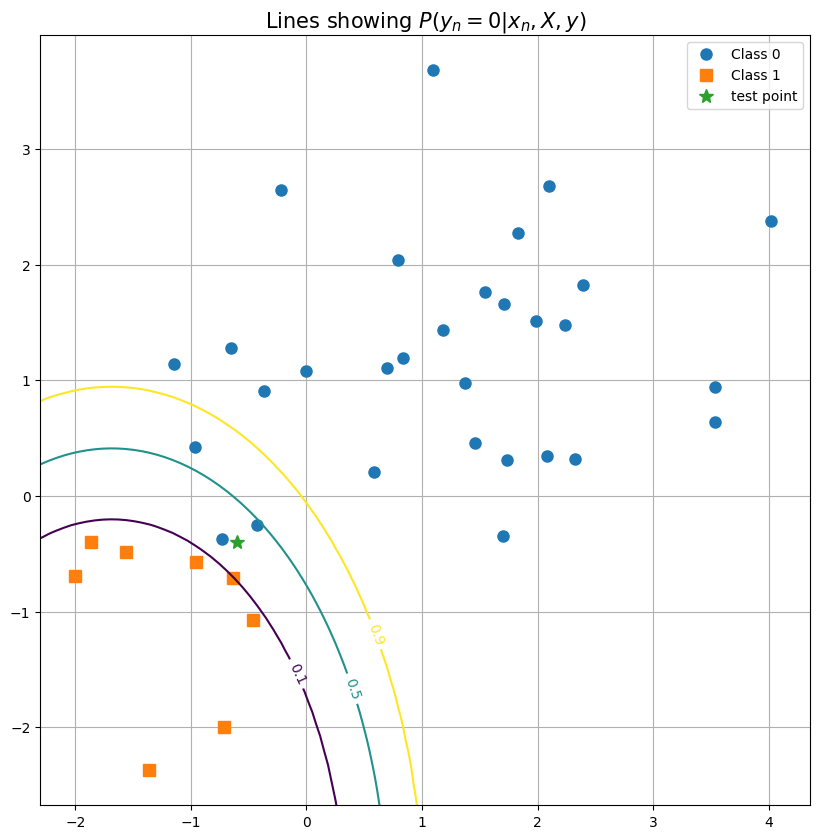

In [8]:
# Define and train the model
model = GaussianNaiveBayes()
model.fit(X_train, y_train)

# Prediction
y_pred_train, _ = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test,y_pred_prob_test = model.predict(X_test)
print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, y_pred_prob_test[0,y_pred_test]))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Lines showing $P(y_{n} = 0 | x_{n}, X, y)$')
fig, ax = decision_boundary(model, fig, ax, labels = True)

# 3. SVM (5 pts)


### Excercise 3.1 (3 pts)
The SVM classifier is most often phrased as the constrained optimization problem:
$$
\begin{aligned}
 \underset{w,b}{\arg\min}\ & \frac{1}{2} w^T w \\
 s.t. \quad & t_n(w^T x_n + b) \geq 1, \forall n,
 \end{aligned}
$$
where $t_n \in \{-1,1\}$ are now the associated labels ($y_n = 0 \iff t_n = -1$; $y_n = 1 \iff t_n = 1$).

By moving the constraints into the objective function, we may formulate the problem using the *hinge* loss function:
$$
    J =  \frac{1}{2} w^T w + C\frac{1}{N} \sum_{n=1}^N \max(0, 1 - t_n(w^T x_n + b)),
$$
with $C$ as a regularization parameter.

Even though the *hinge* loss function is not differentiable, it is still a convex function and has subgradients with respect to both $w$ and $b$. Thus, it can still be used for optimization.
Derive the following subgradients:
$$
\frac{\partial J}{\partial w}, \quad
\frac{\partial J}{\partial b}.
$$

Firstly, define $H_n$ as the expression within the sum, i.e

$$
H_n = 
\begin{cases}
0, \text{ if } t_n(w^Tx_n+b)\geq 1,\\
1-t_n(w^tx_n+b), \text{ else }
\end{cases}.
$$

Taking the subgradients of $H_n$ with respect to the different variables results in

$$
\frac{\partial H}{\partial w} = h_n^{(w)} = 
\begin{cases}
0, \text{ if } t_n(w^Tx_n+b)\geq 1 \\
-t_nx_n, \text{ else }
\end{cases}, \:\:\:\:\:\:\:\:\:\:
\frac{\partial H}{\partial b} = h_n^{(b)} =
\begin{cases}
0, \text{ if } t_n(w^Tx_n+b)\geq 1 \\
-t_n, \text{ else }
\end{cases}. 
$$

Thus, the total subgradients for $J$ will be equal to

$$
\frac{\partial J}{\partial w} = w+C\cdot\frac{1}{N}\sum_{n=1}^N h_n^{(w)}, \:\:\:\:\:\:\:\:\:\: \frac{\partial J}{\partial b} = C\cdot\frac{1}{N}\sum_{n=1}^N h_n^{(b)}. 
$$

### Excercise 3.2 (2 pts)
Here, you will finish a custom implementation of a SVM classifier.

The most important variables stored by the algorithm are:
* `self.C`: Regularization parameter.
* `self.parameters`: Dictionary containing the model parameters $w$ and $b$.

Using the subderivatives derived in Exercise 3.1, complete the unfinished function `grad_cost(self, X_train, t, w, b)`, which should return the cost functions and the derivatives of the cost function w.r.t $w,b$.

Also, finish the function `predict(self, X_test)` using the appropriate prediction strategy for SVM.

In [9]:
class SVM():
    """
    Custom implementation of linear SVM.
    """
    def __init__(self, learning_rate, n_iterations, C = 1, print_cost=False):
        """
        Parameter(s):
            learning_rate - Learning rate
            n_iterations  - Number of iterations
            C             - Regularization parameter
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.C = C
        self.print_cost = print_cost
        self.parameters = {}

    def initialize_parameters(self, n_features):
        """
        Initialize model parameters with zeros:
            w.shape = (n_features, 1)
            b.shape = (1,)
        --------------------
        Input(s):
            n_features - Number of features
        --------------------
        Output(s):
        """

        w = np.zeros(shape = (n_features,1))
        b = 0

        self.parameters["w"] = w
        self.parameters["b"] = b


    def grad_cost(self, X_train, t, w, b):
        """
        Computes the cost function (hinge loss) and
        partial derivatives of cost w.r.t the model parameters.
        --------------------
        Input(s):
            X_train - Data of size(n_samples, n_features)
            t       - Labels (-1 or 1) of size (n_samples,)
            w,b     - Model parameters
        --------------------
        Output(s):
            cost  - hinge loss
            grads - Gradients of loss function w.r.t model parameters (dw,db).
        """
        n_samples = X_train.shape[0]

        # Calculate the cost for H, for all n as sums
        cost_H = sum([(1-t[n]*(np.transpose(w)@X_train[n]+b))[0] if (1-t[n]*(np.transpose(w)@X_train[n]+b))[0]>0 else 0 for n in range(n_samples)])
        cost_Hw = sum([-t[n]*X_train[n] if (1-t[n]*(np.transpose(w)@X_train[n]+b))[0] > 0 else 0 for n in range(n_samples)])
        cost_Hw = np.reshape(cost_Hw, newshape = (w.shape[0], w.shape[1])) #reshape for correct dimensions
        cost_Hb = sum([-t[n] if (1-t[n]*(np.transpose(w)@X_train[n]+b))[0] > 0 else 0 for n in range(n_samples)])
        
        # Calculate the cost, and its derivaties
        cost = (1/2) * (np.transpose(w)@w)+self.C*(1/n_samples)*cost_H
        dw = w+self.C*(1/n_samples)*cost_Hw
        db = self.C*(1/n_samples)*cost_Hb
        

        grads = {"dw": dw,
                 "db": db}

        return cost, grads

    def fit(self, X_train, y_train):
        """
        Optimize model parameters by running a gradient descent algorithm.
        --------------------
        Input(s):
            X_train - Data of size (n_samples, n_features)
            y_train - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """
        n_features = X_train.shape[1]

        # Change the binary targets from (0,1) to (-1,1)
        t = np.where(y_train < 0.5, -1, 1)

        # Initialize parameters
        self.params = self.initialize_parameters(n_features)

        # Gradient descent
        w = self.parameters["w"]
        b = self.parameters["b"]
        for i in range(1,self.n_iterations+1):
            cost, grads = self.grad_cost(X_train, t, w, b)
            dw = grads["dw"]
            db = grads["db"]

            w -= self.learning_rate * dw
            b -= self.learning_rate * db

            if self.print_cost and i % 100 == 0:
                print("Cost after iteration %i: %f" %(i, cost))

        self.parameters = {"w": w,
                           "b": b}

        return self

    def predict(self, X_test):
        """
        Binary prediction of test data.
        --------------------
        Input(s):
            X   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels (0/1) of size (n_samples,1)
        """

        w = self.parameters["w"]
        b = self.parameters["b"]

        n_samples = X_test.shape[0]
        y_pred = np.zeros((n_samples,1))

        for i in range(n_samples):
            y_pred[i] = np.sign(np.transpose(w)@X_test[i]+b) # Prediction
        

        # Converts the binary targets from (-1,1) to (0,1)
        y_pred = (y_pred > 0).astype(np.int32)

        return y_pred.squeeze()

#### Run the code below after finishing the above implementation (no need to change anything).
Make sure that you understand the plot and that your implementation produces sensible results.

C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\1747755469.py:56: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  cost_Hw = np.reshape(cost_Hw, newshape = (w.shape[0], w.shape[1])) #reshape for correct dimensions
C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\1747755469.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Cost after iteration %i: %f" %(i, cost))


Cost after iteration 100: 0.716996
Cost after iteration 200: 0.702944
Cost after iteration 300: 0.698494
Cost after iteration 400: 0.697115
Cost after iteration 500: 0.696911
Cost after iteration 600: 0.696872
Cost after iteration 700: 0.696847
Cost after iteration 800: 0.696855
Cost after iteration 900: 0.696887
Cost after iteration 1000: 0.696830
Train accuracy: 100.000 %
Predicted test class: 0


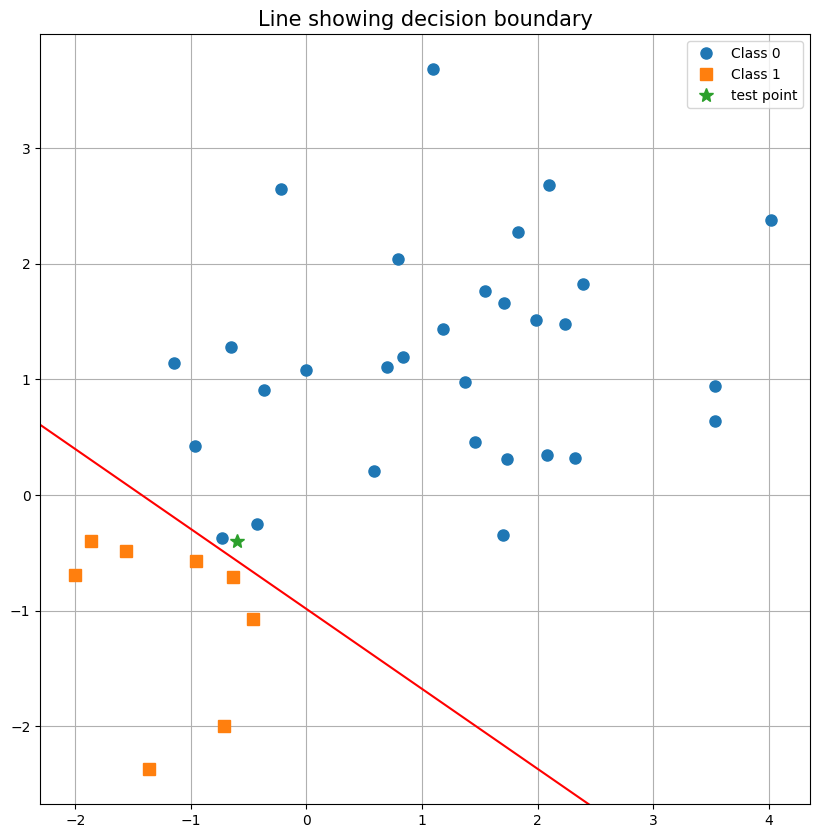

In [10]:
# Parameters (feel free to change)
learning_rate = 0.01
n_iterations = 1000
C = 2.5
print_cost = True

# Define and train the model
model = SVM(learning_rate, n_iterations, C, print_cost)
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test = model.predict(X_test)
print("Predicted test class: %d" %(y_pred_test))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Line showing decision boundary')
w = model.parameters['w']
b = model.parameters['b']
x = np.linspace(-3,3)
ax.plot(x, (-b-w[0]*x)/w[1], '-r')

# 4. Logistic Regression (3 pts)

### Excercise 4.1 (3 pts)
The last classifier that we will look at is Logistic Regression. Here you will finish a custom implementation of the Logistic Regression classifier using the following information:

* The activation is computed as
$$
A = \sigma(X w + b) = [a_1, \ldots, a_N]^T,
$$
where $\sigma(z)$ is the sigmoid-function.

* The cost function is the negative log-likelihood:
$$
J = -\frac{1}{N}\sum_{n=1}^{N}y_n\log(a_n)+(1-y_n)\log(1-a_n).
$$

* Derivatives w.r.t the model parameters:
$$
 \frac{\partial J}{\partial w} = \frac{1}{N}X^T(A-Y), \qquad
\frac{\partial J}{\partial b} = \frac{1}{N} \sum_{n=1}^N (a_n-y_n).
$$

Finish the implementation of `grad_cost(self, X_train, y_train, w, b)`, which once again should return the cost functions and the derivatives of the cost function w.r.t $w,b$.

Also, finish the function `predict(self, X_test)` using the appropriate prediction strategy for Logistic Regression.

In [11]:
class LogisticRegression():
    """
    Custom implementation of (binary) Logistic Regression.
    """
    def __init__(self, learning_rate, n_iterations, print_cost=False):
        """
        Parameter(s):
            learning_rate - Learning rate
            n_iterations  - Number of iterations
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.print_cost = print_cost
        self.parameters = {}

    def initialize_parameters(self, n_features):
        """
        Initialize model parameters with zeros:
            w.shape = (n_features,)
            b.shape = (1,)
        --------------------
        Input(s):
            n_features - Number of features
        --------------------
        Output(s):
        """

        w = np.zeros(shape = (n_features,1))
        b = 0

        self.parameters['w'] = w
        self.parameters['b'] = b

    def sigmoid(self, z):
        """
        Sigmoid function
        --------------------
        Input(s):
            z -
        --------------------
        Output(s):
            s - sigmoid(z)
        """
        s = 1 / (1 + np.exp(-z))
        return s

    def grad_cost(self, X_train, y_train, w, b):
        """
        Computes the cost function (negative log-likelihood) and
        partial derivatives of cost w.r.t the model parameters.
        --------------------
        Input(s):
            X_train - Data of size(n_samples, n_features)
            y_train - True labels of size (n_samples,1)
            w,b     - Model parameters
        --------------------
        Output(s):
            cost  - Negative log-likelihood cost
            grads - Gradients of loss function w.r.t model parameters (dw,db).
        """
        n_samples = X_train.shape[0]

        y_train = y_train.reshape(-1,1)


        A = self.sigmoid(np.dot(X_train, w) + b)
        cost = -1/n_samples * np.sum(y_train*np.log(A) + (1-y_train)*np.log(1-A))
        dw = 1/n_samples * np.dot(X_train.T, (A-y_train))
        db = 1/n_samples * np.sum(A-y_train)

        grads = {"dw": dw,
                 "db": db}

        return cost, grads

    def fit(self, X_train, y_train):
        """
        Optimize model parameters by running a gradient descent algorithm.
        --------------------
        Input(s):
            X_train - Data of size (n_samples, n_features)
            y_train - True labels of size (n_samples,1)
        --------------------
        Output(s)
        """
        n_features = X_train.shape[1]

        # Initialize parameters
        self.params = self.initialize_parameters(n_features)

        # Gradient descent
        w = self.parameters["w"]
        b = self.parameters["b"]
        for i in range(1,self.n_iterations+1):
            cost, grads = self.grad_cost(X_train, y_train, w, b)
            dw = grads["dw"]
            db = grads["db"]

            w -= self.learning_rate * dw
            b -= self.learning_rate * db

            if self.print_cost and i % 100 == 0:
                print("Cost after iteration %i: %f" %(i, cost))

        self.parameters = {"w": w,
                           "b": b}

        return self

    def predict(self, X_test):
        """
        Binary prediction of test data.
        --------------------
        Input(s):
            X   - Data of size (n_samples, n_features)
        --------------------
        Output(s)
            y_pred - Predicted labels (0/1) of size (n_samples,)
        """

        w = self.parameters["w"]
        b = self.parameters["b"]

        n_samples = X_test.shape[0]
        y_pred = np.zeros((n_samples,1))

        probs = self.sigmoid(np.dot(X_test, w) + b)
        A = np.array([1-probs,probs])
        for i in range(n_samples):
            if A[1,i] > 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0

        return y_pred.squeeze(), A

#### Run the code below after finishing the above implementation (no need to change anything).
Make sure that you understand the plot and that your implementation produces sensible results.

Cost after iteration 100: 0.180875
Cost after iteration 200: 0.138702
Cost after iteration 300: 0.119734
Cost after iteration 400: 0.108276
Cost after iteration 500: 0.100370
Cost after iteration 600: 0.094472
Cost after iteration 700: 0.089841
Cost after iteration 800: 0.086068
Cost after iteration 900: 0.082909
Cost after iteration 1000: 0.080206
Train accuracy: 97.368 %
Predicted test class: 1, (prob 0.56)


C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\3779382297.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, np.where(y_pred_prob_test[1] < 0.5, 1-y_pred_prob_test[1], y_pred_prob_test[1])))
C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\1381338663.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[j,i] = y_prob[0,0]


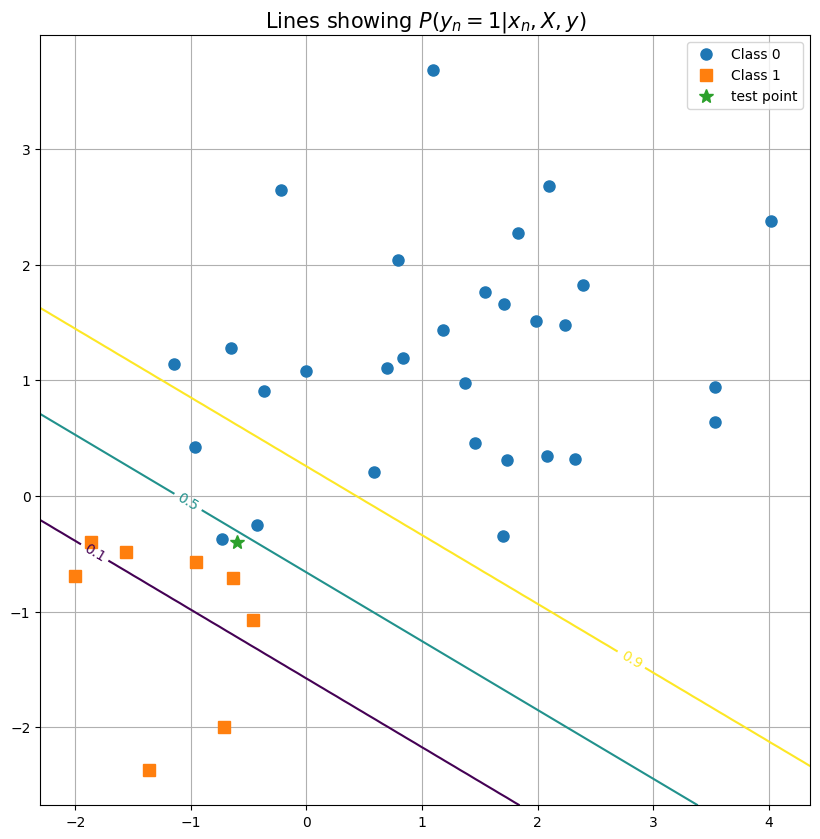

In [12]:
# Parameters (feel free to change)
learning_rate = 0.05
n_iterations = 1000
print_cost = True

# Define and train the model
model = LogisticRegression(learning_rate, n_iterations, print_cost)
model.fit(X_train, y_train)

# Predictions
y_pred_train, _ = model.predict(X_train)
print("Train accuracy: %.3f %%" %(np.mean(y_pred_train == y_train)*100))
y_pred_test,y_pred_prob_test = model.predict(X_test)
print("Predicted test class: %d, (prob %.2f)" %(y_pred_test, np.where(y_pred_prob_test[1] < 0.5, 1-y_pred_prob_test[1], y_pred_prob_test[1])))

# Plot decision-boundaries
fig, ax = plot_data(X_train, y_train, X_test, title = 'Lines showing $P(y_{n} = 1 | x_{n}, X, y)$')
fig, ax = decision_boundary(model, fig, ax, labels = True)

# 5. (0 pts)

Finally, lets apply all four of our implemented classifiers to a real world dataset about breast cancer. The [UCI ML Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) dataset contains characteristics of the cell nuclei, which can be used to predict whether a tumor is malignant or benign.

First, lets import the dataset and split it into a train- and test set.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the breast cancer dataset
X, y = load_breast_cancer(return_X_y=True)
X = X[:,:10] # Only looking at the first 10 features (the mean values)
X = StandardScaler().fit_transform(X)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=0)

print('Training set:\t', X_train_new.shape,  y_train_new.shape)
print('Test set:\t', X_test_new.shape,  y_test_new.shape)

Training set:	 (455, 10) (455,)
Test set:	 (114, 10) (114,)


Now we set the parameters for all of our classifiers and train each one of them and report the average train- and test accuracy.

In [13]:
# Parameters (feel free to change)
learning_rate = 0.05
n_iterations = 1000
C = 10
print_cost = False
K = 5

# Define all models
models = {"KNN":K_Nearest_Neighbors(n_neighbors = K),
          "SVM":SVM(learning_rate, n_iterations, C, print_cost),
          "LR":LogisticRegression(learning_rate, n_iterations, print_cost),
          "GNB":GaussianNaiveBayes()}

# Train all models and report performance
for name, model in models.items():
    print(name)
    model.fit(X_train_new, y_train_new)
    if name == "SVM":
        y_pred_train = model.predict(X_train_new)
        y_pred_test = model.predict(X_test_new)
    else:
        y_pred_train,_ = model.predict(X_train_new)
        y_pred_test,_ = model.predict(X_test_new)
    print("\tTrain accuracy: %.3f %%" %(np.mean(y_pred_train == y_train_new)*100))
    print("\tTest accuracy: %.3f %%" %(np.mean(y_pred_test == y_test_new)*100))

KNN
	Train accuracy: 96.484 %
	Test accuracy: 91.228 %
SVM


C:\Users\nilsl\AppData\Local\Temp\ipykernel_46000\1747755469.py:56: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  cost_Hw = np.reshape(cost_Hw, newshape = (w.shape[0], w.shape[1])) #reshape for correct dimensions


	Train accuracy: 93.846 %
	Test accuracy: 94.737 %
LR
	Train accuracy: 94.725 %
	Test accuracy: 93.860 %
GNB
	Train accuracy: 92.088 %
	Test accuracy: 88.596 %
